https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://github.com/an-rivas/ENDIREH-data-analysis/blob/preprocesamiento4Cat/OE1_Exploracion/Baseline/Baseline.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

In [1]:
import pandas as pd
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, obtenerOhe

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
from sklearn import tree #La versión que tengo es 0.24.1 y está disponible apartir de la 0.21
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [3]:
endireh = CargarPandasDatasetCategoricos('datasets/endireh.csv')

In [4]:
endireh.shape

(23669, 73)

## Preprocesamiento

**Random forest no usan datos categóricos (object type), para ello obtengo One Hot Encoding con la instruccion pd.get_dummies de pandas para las columnas categóricas**

Solo nos quedamos con las que sufieron violencia

In [5]:
endireh.drop(endireh[endireh["P9_8"]==3].index, axis=0, inplace=True)

In [6]:
endireh.shape

(6771, 73)

Obtengo la variable objetivo _y_.

In [7]:
y = endireh['P9_8'].copy()

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [8]:
endireh.drop(columns=['P9_8', 'REGION'], inplace=True)

Obtengo el OHE en las variables categoricas que no sean ohe

In [9]:
endireh_ohe = obtenerOhe(endireh)

In [10]:
endireh_ohe

,CVE_ENT_1,CVE_ENT_10,CVE_ENT_11,CVE_ENT_12,CVE_ENT_13,CVE_ENT_14,CVE_ENT_15,CVE_ENT_16,CVE_ENT_17,CVE_ENT_18,...,P9_5_3,P9_5_4,P9_5_5,P9_5_6,P9_5_7,P9_5_8,P9_5_9,P9_5_10,P9_5_11,P9_5_12
12,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23652,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23654,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23663,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23664,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
y

12       0
13       1
14       0
15       2
17       1
        ..
23652    0
23654    0
23663    2
23664    1
23666    1
Name: P9_8, Length: 6771, dtype: int64

In [12]:
y.value_counts()

0    3512
2    1790
1    1469
Name: P9_8, dtype: int64

## Encontrar los mejores parámetros con _Grid Search_

Declaramos los parametros

In [44]:
param_grid = ParameterGrid(
                    {
                     'criterion'         : ['gini', 'entropy'],
                     'min_samples_split' : range(25,401, 5),
                     'max_features'      : ['auto', 'sqrt', 'log2'],
                     'random_state'      : [42, 666, 5],
                     'warm_start'        : [True, False],
                     'max_samples'       : [0.7, 0.8],
                    }
                )

len(param_grid)

27360

Creamos el diccionario que guadará los resultados

In [40]:
resultados = {'params': [], 'oob_accuracy': [], 'f1': []}
importances = []
bestSoFar = [0,0] ## oob score and model

 de donde saque como hacer el f1 https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method

### Loop para ajustar un modelo con cada combinación de hiperparámetros

In [41]:
%%time
print(f'Creando modelos para {len(param_grid)} combinaciones de parámetros.\n')

for i,params in enumerate(param_grid):
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                ** params
             )
    
    modelo.fit(endireh_ohe, y)
    
    pred_train = np.argmax(modelo.oob_decision_function_,axis=1).round()
    #pred_train = modelo.oob_decision_function_[:, 1]
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    resultados['f1'].append(f1_score(y, pred_train, average='micro'))
    
    if(modelo.oob_score_ > bestSoFar[0]):
        bestSoFar[0] = modelo.oob_score_
        bestSoFar[1] = modelo
    
    importances.append(modelo.feature_importances_)
    
    if i%450 == 0 or i==len(param_grid):
        print(f"Modelo {i}: {params} \u2713 ({modelo.oob_score_})")

print('\n')

Creando modelos para 5472 combinaciones de parámetros.

Modelo 0: {'criterion': 'gini', 'max_features': 'auto', 'max_samples': 0.7, 'min_samples_split': 25, 'random_state': 42, 'warm_start': True} ✓ (0.5312361541869739)
Modelo 450: {'criterion': 'gini', 'max_features': 'auto', 'max_samples': 0.7, 'min_samples_split': 400, 'random_state': 42, 'warm_start': True} ✓ (0.5299069561364643)
Modelo 900: {'criterion': 'gini', 'max_features': 'auto', 'max_samples': 0.8, 'min_samples_split': 395, 'random_state': 42, 'warm_start': True} ✓ (0.5290208241027913)
Modelo 1350: {'criterion': 'gini', 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_split': 390, 'random_state': 42, 'warm_start': True} ✓ (0.5297592674641854)
Modelo 1800: {'criterion': 'gini', 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_split': 385, 'random_state': 42, 'warm_start': True} ✓ (0.5290208241027913)
Modelo 2250: {'criterion': 'gini', 'max_features': 'log2', 'max_samples': 0.7, 'min_samples_split': 380, 'rand

## Visualizamos resultados

### 7 de enero de 2022 3528 combinaciones

    param_grid = ParameterGrid(
                    {
                     ## 'n_estimators' se deja el default de 100
                     'criterion'         : ['gini', 'entropy'],
                     'min_samples_split' : range(50, 501, 20),
                     'max_features'      : ['auto', 'sqrt', 'log2'],
                     ## 'bootstrap'         : [True, False], ## cuando se use el falso no debe pasarse oob_score
                     ## 'oob_score'         : [True, False],
                     'random_state'      : [42, 666, 5],
                     'warm_start'        : [True, False],
                     'max_samples'       : [0.7, 0.8],
                    }
                )
            
Duró 23 hrs 50 min.

In [42]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,f1,criterion,max_features,max_samples,min_samples_split,random_state,warm_start
1400,0.532565,0.532565,gini,sqrt,0.8,50,666,True
488,0.532565,0.532565,gini,auto,0.8,50,666,True
1401,0.532565,0.532565,gini,sqrt,0.8,50,666,False
489,0.532565,0.532565,gini,auto,0.8,50,666,False
2823,0.532418,0.532418,entropy,auto,0.7,95,666,False
3735,0.532418,0.532418,entropy,sqrt,0.7,95,666,False
2822,0.532418,0.532418,entropy,auto,0.7,95,666,True
3734,0.532418,0.532418,entropy,sqrt,0.7,95,666,True
4376,0.532270,0.532270,entropy,sqrt,0.8,250,666,True
4377,0.532270,0.532270,entropy,sqrt,0.8,250,666,False


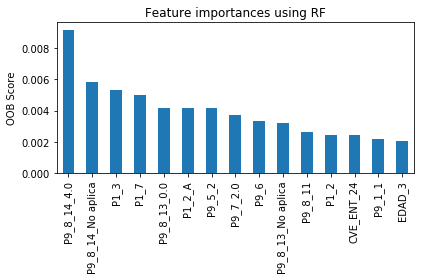

In [43]:
#plt.barh(endireh_ohe.columns, importances[903])

forest_importances = pd.Series(importances[1400], index=endireh_ohe.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances[:15].plot.bar(ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("OOB Score")
fig.tight_layout()

### 3 de enero de 2022 3528 combinaciones

    param_grid = ParameterGrid(
                    {
                     ## 'n_estimators' se deja el default de 100
                     'criterion'         : ['gini', 'entropy'],
                     'min_samples_split' : range(50, 501, 20),
                     'max_features'      : ['auto', 'sqrt', 'log2'],
                     ## 'bootstrap'         : [True, False], ## cuando se use el falso no debe pasarse oob_score
                     ## 'oob_score'         : [True, False],
                     'random_state'      : [42, 666, 5],
                     'warm_start'        : [True, False],
                     'max_samples'       : [0.7, 0.8],
                    }
                )
            
Puesto a las 10:15 hrs. De acuerdo a la libreta _2-BaselineGridForest.ipynb_ durará poco menos de 24.

In [16]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,criterion,max_features,max_samples,min_samples_split,random_state,warm_start
1400,0.532565,gini,sqrt,0.8,50,666,True
488,0.532565,gini,auto,0.8,50,666,True
1401,0.532565,gini,sqrt,0.8,50,666,False
489,0.532565,gini,auto,0.8,50,666,False
2823,0.532418,entropy,auto,0.7,95,666,False
3735,0.532418,entropy,sqrt,0.7,95,666,False
2822,0.532418,entropy,auto,0.7,95,666,True
3734,0.532418,entropy,sqrt,0.7,95,666,True
4376,0.532270,entropy,sqrt,0.8,250,666,True
4377,0.532270,entropy,sqrt,0.8,250,666,False


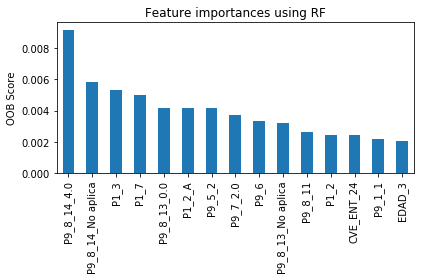

In [19]:
#plt.barh(endireh_ohe.columns, importances[903])

forest_importances = pd.Series(importances[1400], index=endireh_ohe.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances[:15].plot.bar(ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("OOB Score")
fig.tight_layout()